## Tests on the London Smart Meter Data using WGAN with gradient penalty (WGAN-GP)

In [ ]:
import torch
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch.utils.data import Dataset, DataLoader

class DatasetLondonSmartMeter(Dataset):

  def __init__(self, assets = ['MAC000008', 'MAC000002'], window = 24, overlap = 23, data_dir = '/content/drive/MyDrive/Data/'):
      super().__init__()
      self.assets = assets
      self.data_dir = data_dir
      self.file_name = f'{str(assets)}_train_data_London_{window}_{overlap}.pkl'
      data_path = os.path.join(data_dir, self.file_name)
      self.data = torch.load(data_path)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    sample = self.data[index]
    return sample




8992


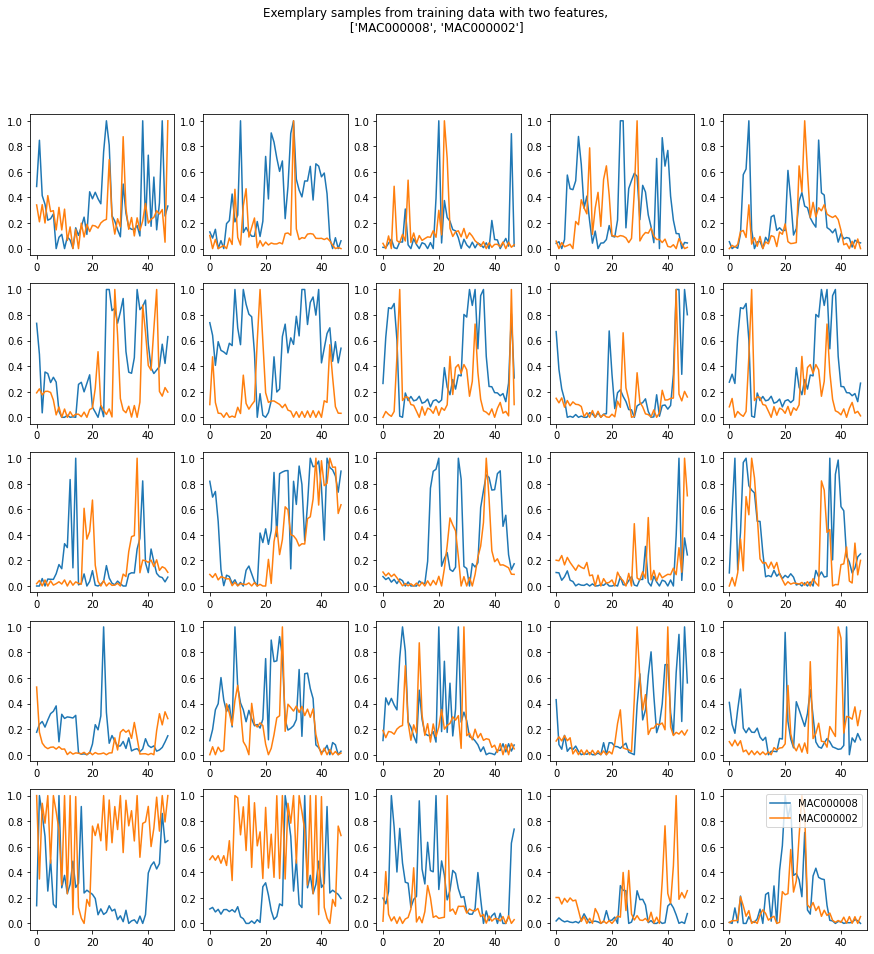

In [ ]:
dataset = DatasetLondonSmartMeter()
print(len(dataset))
loader = DataLoader(dataset, shuffle=True, batch_size = 64)
plt.figure(figsize=(15,15))
for k in range(25):
  plt.subplot(5,5, k+1)
  x = next(iter(loader)).detach().cpu().numpy()
  plt.plot(x[k,0,:], label=dataset.assets[0])
  plt.plot(x[k,1,:], label=dataset.assets[1])
plt.legend()
plt.suptitle(f'Exemplary samples from training data with two features,\n {dataset.assets}')
plt.show()



In [ ]:
import torch.nn as nn
from torch.nn.utils import spectral_norm
from collections import defaultdict
from IPython.display import clear_output

Define Critic and Generator 

In [ ]:
class Critic(nn.Module):
    """
    Critic: Replaces the discriminator network in the WGAN.

    """

    def __init__(self, input_shape = (2,48), kernel_size = 7,
                 padding = 3, stride = 2):

        super(Critic, self).__init__()
        self.input_shape = input_shape
        self.features = input_shape[0]
        self.seq_len = input_shape[1]  
        self.relu_slope = 0.2  # slope of leaky ReLU in sequential block
        self.stride = stride
        self.kernel_size = kernel_size
        self.padding = padding
        self.dilation = 1

        def dis_block(in_channel, out_channel):
            layers = [
                spectral_norm(
                    nn.Conv1d(in_channel, out_channel, self.kernel_size, stride=self.stride, padding=self.padding,
                              dilation=self.dilation), n_power_iterations=10),
                # use of spectral normalization helps fulfill the Lipschitz constraint
                nn.LeakyReLU(self.relu_slope),
            ]

            return layers

        self.model = nn.Sequential(
            *dis_block(self.features, 16),
            *dis_block(16, 32),
            *dis_block(32, 64),
            *dis_block(64, 128),
        )
        ds_size = int(np.ceil(self.input_shape[1] / 2 ** 4))
        # sequence length reduces in Critic per every epoch:
        # example: after 4 epochs for seq_len of 24: ds_size=ceil(24/2**4)=2
        self.fc = nn.Sequential(
            nn.Linear(128 * ds_size, 64),
            nn.LeakyReLU(self.relu_slope)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(64, 1),
        )

    def forward(self, x):
      if x.dim() == 2:
          x = x.view(x.size(0), 1, -1)
      out = self.model(x)
      out = out.view(out.size(0), -1)
      feature = self.fc(out)
      validity = self.fc2(feature)
      return validity

In [ ]:
class Generator(nn.Module):
    """ Generator network of WGAN model. """

    def __init__(self, input_shape=(2,48), z_dim: int =100, relu_slope=0.2, kernel_size = 3,
                 padding = 1, stride = 1, activ_fct = None):
      
        super(Generator, self).__init__()
        self.input_shape = input_shape
        self.latent_dim = z_dim  # dimension of input noise
        self.activ_fct = activ_fct  # used in output layer
        self.init_size = int(np.ceil(input_shape[1] / 4))  # for upsampling
        self.features = input_shape[0]  # number of features
        self.relu_slope = relu_slope  ##to do! Werte ausprobieren ## old value: 0.2
        self.stride = 1
        self.padding = 1
        self.kernel_size = 3
        self.dilation = 1

        self.fc = nn.Sequential(
            nn.Linear(self.latent_dim, 128 * self.init_size)
        )

        self.conv_blocks = nn.Sequential(
            
              nn.Upsample(scale_factor=2),
              nn.Conv1d(128, 128, self.kernel_size, self.stride, self.padding, dilation=self.dilation),
              nn.BatchNorm1d(128),
              nn.LeakyReLU(self.relu_slope, inplace=True),
              nn.Upsample(scale_factor=2),
              nn.Conv1d(128, 64, self.kernel_size, self.stride, self.padding, dilation=self.dilation),
              nn.BatchNorm1d(64),
              nn.LeakyReLU(self.relu_slope, inplace=True),
              nn.Conv1d(64, self.features, self.kernel_size, self.stride, self.padding,
                        dilation=self.dilation)
          )

        if self.activ_fct == 'linear':
            self.activation = nn.Linear(self.features, self.features)

        else:
            self.activation = None

    def forward(self, z):
        out = self.fc(z)  # linear layer
        out = out.view(out.size(0), 128, self.init_size)  # reshape to 3 dim
        x = self.conv_blocks(out)  # conv layers
        if self.activation is not None:  # activation
            x = self.activation(x)
        return x

Add gradient penalty computation function:

In [ ]:

def compute_gp(x_real, x_gen, critic_model,
               device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
  """
  Computation of the gradient penalty term in the loss of the model.

  """

  alpha = np.random.random()  # random number in [0,1]
  interpolate = alpha * x_real + (1 - alpha) * x_gen  # interpolation between real and generated data
  interpolate.requires_grad_(True)
  
  d_inter = critic_model(interpolate)  # discriminator's output on interpolation
  grad_outputs = torch.tensor(np.ones((x_real.size(0), 1)), requires_grad=False).float().to(device)
  gradients = torch.autograd.grad(
      outputs=d_inter,
      inputs=interpolate,
      grad_outputs=grad_outputs,
      create_graph=True,
      retain_graph=True,
      only_inputs=True,
  )[0]  # computation of gradients
  gradients = gradients.view(gradients.size(0), -1).to(device)
  gradients_penalty = (((gradients+1e-6).norm(2, dim=1) - 1) ** 2).mean()  # add small epsilon term for stability
  return gradients_penalty





Define hyperparameters for training:

In [ ]:
input_shape = (2,48)
#kernels
kernel_dis = 7
kernel_gen = 3

#padding 
padding_dis = 3
padding_gen = 1

#stride
stride_gen = 1
stride_dis = 2

#epochs
num_epochs = 2000

#batch size
batch_size = 64

#latent dimension
latent_dim = 100

#number of how often critic is trained more
n_critic = 5

#gradient penalty parameter
lambda_gp = 0.5

loader = DataLoader(dataset, shuffle=True, batch_size = batch_size)


Define functions for loading/saving the model:

In [ ]:
import os

def save_checkpoint(gen_model, dis_model, history, save_path = '/content/drive/MyDrive/ckpt/', save_name='WGANGP_1.pkl'):
  os.makedirs(save_path, exist_ok = True)
  model_state = dict()
  model_state['generator']=gen_model.state_dict()
  model_state['critic']=dis_model.state_dict()
  model_state['history']=history
  torch.save(model_state, save_path + save_name)

In [ ]:

def load_model(save_path = '/content/drive/MyDrive/ckpt/WGANGP_1.pkl',
               device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
  gen_model = Generator(input_shape, relu_slope = 0.2, kernel_size=kernel_gen,
                        padding=padding_gen, stride=stride_gen).to(device)
  critic_model = Critic(input_shape, kernel_dis, padding_dis, stride_dis).to(device)
  history = defaultdict(list)
  if os.path.exists(save_path):
    states = torch.load(save_path, map_location = device)
    history = states['history']
    gen_model.load_state_dict(states['generator'])
    critic_model.load_state_dict(states['critic'])
  return history, gen_model, critic_model


Run Training:

In [ ]:
from collections import defaultdict
from torch.autograd import Variable

Train = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

history, gen_model, critic_model = load_model()


optimizer_g = torch.optim.RMSprop(gen_model.parameters(), lr = 0.0001 )
optimizer_d = torch.optim.RMSprop(critic_model.parameters(), lr=0.0001)

if Train ==True:
  for epoch in range(num_epochs):
    local_history = dict()
    temp_history = defaultdict(list)
    for i, x_batch in enumerate(loader):
      x_batch = Variable(x_batch.float()).to(device)
      batch_size = x_batch.size(0)
      z = Variable(torch.randn((batch_size, latent_dim )).float()).to(device)
      x_gen = gen_model(z)
      optimizer_d.zero_grad()
      gradients_penalty = compute_gp(x_batch.data, x_gen.data, critic_model)
      d_loss = torch.mean(critic_model(x_gen)) - torch.mean(critic_model(x_batch)) \
                      + lambda_gp * gradients_penalty 
      d_loss.backward()
      optimizer_d.step()
      temp_history['d_loss'].append(d_loss.item())
    # train generator only every i-th iteration
      if i % n_critic == 0:
        optimizer_g.zero_grad()
        x_gen = gen_model(z)
        g_loss = -torch.mean(critic_model(x_gen))
        g_loss.backward()
        optimizer_g.step()
        temp_history['g_loss'].append(g_loss.item())
    local_history['d_loss'] = np.mean(temp_history['d_loss'])
    local_history['g_loss'] = np.mean(temp_history['g_loss'])
    for k, v in local_history.items():
      history[k].append(v)
    if (epoch +1) % 10 == 0 or (epoch +1) == num_epochs:
      save_checkpoint(gen_model, critic_model, history)
      num = len(str(num_epochs))
      d_loss = local_history['d_loss']
      g_loss = local_history['g_loss']
      print(f'Epoch {epoch +1}: loss critic: {d_loss:2f}, loss generator: {g_loss:2f}')



Plot losses of Generator/Critic:

In [ ]:
import seaborn as sns
history, gen_model, critic_model = load_model()

def plot_losses(history):
    """
    Plots losses of critic/discriminator and generator for each training epoch.
    """
    critic_loss = history['d_loss']
    gen_loss = history['g_loss']

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
    ax1.semilogx(critic_loss, color='black', linewidth=0.5)
    ax1.set_title('Critic Loss')
    ax2.semilogx(gen_loss, color='black', linewidth=0.5)
    ax2.set_title('Generator Loss')
    ax2.set_xlabel('epochs')
    sns.despine(left=True, bottom=True, right=True)

    return fig

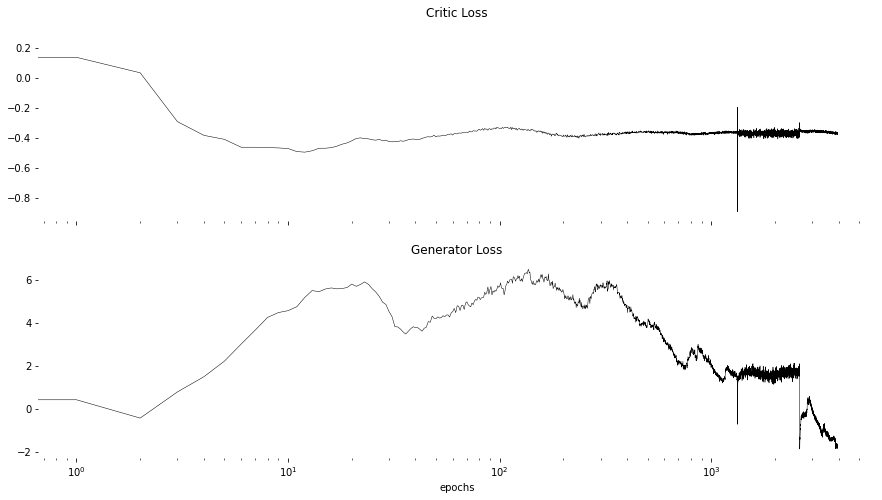

In [ ]:
fig_losses = plot_losses(history)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def generate_samples(gen_model, size=1000, clip=False):
  z = torch.randn(size,100).to(device)
  gen_model.eval()
  x_gen = gen_model(z).detach()
  if clip:
    x_gen = torch.clamp(x_gen, 0,1)
  return x_gen



Visualize generated samples:

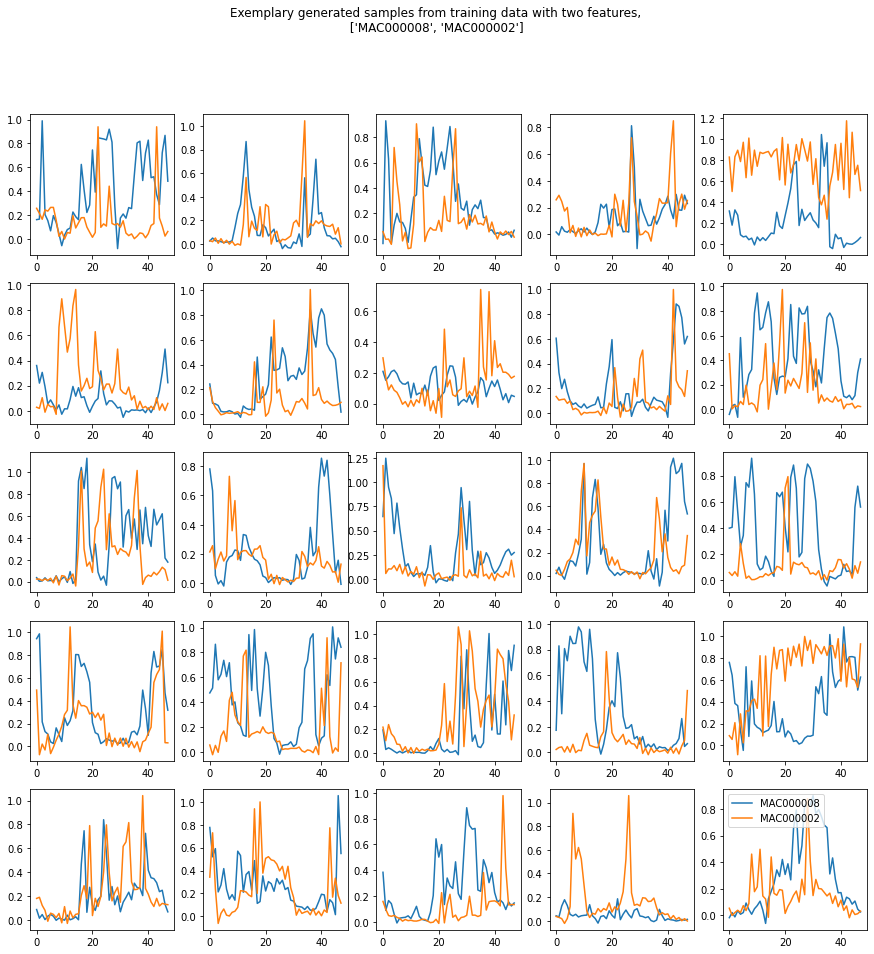

In [ ]:
x_gen = generate_samples(gen_model, 32).cpu().numpy()
plt.figure(figsize=(15,15))
for k in range(25):
  plt.subplot(5,5, k+1)
  plt.plot(x_gen[k,0,:], label=dataset.assets[0])
  plt.plot(x_gen[k,1,:], label=dataset.assets[1])
plt.legend()
plt.suptitle(f'Exemplary generated samples from training data with two features,\n {dataset.assets}')
plt.show()


In [ ]:
def add_gaussian_noise(x, variance=0.01):
  batch_size, feature_dim, seq_len = x.shape
  noise =(variance**0.5)*torch.randn(batch_size, feature_dim, seq_len)
  x_transposed = x + noise
  return x_transposed

Visualization using t-SNE:

In [ ]:
def load_real_data(dataset, size=1000):
  idx = np.random.permutation(len(dataset))[:size]
  data = dataset.data
  return data[idx]

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def t_SNE(x_real, x_fake, feature_mean=True, perplexity=80):
    x_real = x_real.cpu().numpy()
    x_fake = x_fake.cpu().numpy()
    seq_len = x_real.shape[-1]

    samples, dim, seq_len = x_real.shape
    if feature_mean:
      for i in range(samples):
          if i == 0:
              prep_data = np.reshape(np.mean(x_real[0, :, :], 0), [1, seq_len])
              prep_data_hat = np.reshape(np.mean(x_fake[0, :, :], 0), [1, seq_len])
          else:

              prep_data = np.concatenate((prep_data,
                                          np.reshape(np.mean(x_real[i, :, :], 0), [1, seq_len])))
              prep_data_hat = np.concatenate((prep_data_hat,
                                              np.reshape(np.mean(x_fake[i, :, :], 0), [1, seq_len])))
              
    else:
      prep_data = x_real.reshape(-1,seq_len)
      prep_data_hat = x_fake.reshape(-1, seq_len)
          

    prep_data_final = np.concatenate((prep_data, prep_data_hat), axis=0)

    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=1000)
    tsne_embedding = tsne.fit_transform(prep_data_final)
    
    indx = len(prep_data)
    x_real_embedded = tsne_embedding[:indx]
    x_fake_embedded = tsne_embedding[indx:]

    return x_real_embedded, x_fake_embedded

In [ ]:
x_real = load_real_data(dataset, size=10000)
x_fake = generate_samples(gen_model, size=10000)


In [ ]:
x_real_embedded, x_fake_embedded = t_SNE(x_real, x_fake, feature_mean = False)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 37984 samples in 0.001s...
[t-SNE] Computed neighbors for 37984 samples in 24.538s...
[t-SNE] Computed conditional probabilities for sample 1000 / 37984
[t-SNE] Computed conditional probabilities for sample 2000 / 37984
[t-SNE] Computed conditional probabilities for sample 3000 / 37984
[t-SNE] Computed conditional probabilities for sample 4000 / 37984
[t-SNE] Computed conditional probabilities for sample 5000 / 37984
[t-SNE] Computed conditional probabilities for sample 6000 / 37984
[t-SNE] Computed conditional probabilities for sample 7000 / 37984
[t-SNE] Computed conditional probabilities for sample 8000 / 37984
[t-SNE] Computed conditional probabilities for sample 9000 / 37984
[t-SNE] Computed conditional probabilities for sample 10000 / 37984
[t-SNE] Computed conditional probabilities for sample 11000 / 37984
[t-SNE] Computed conditional probabilities for sample 12000 / 37984
[t-SNE] Computed conditional probabilities for s

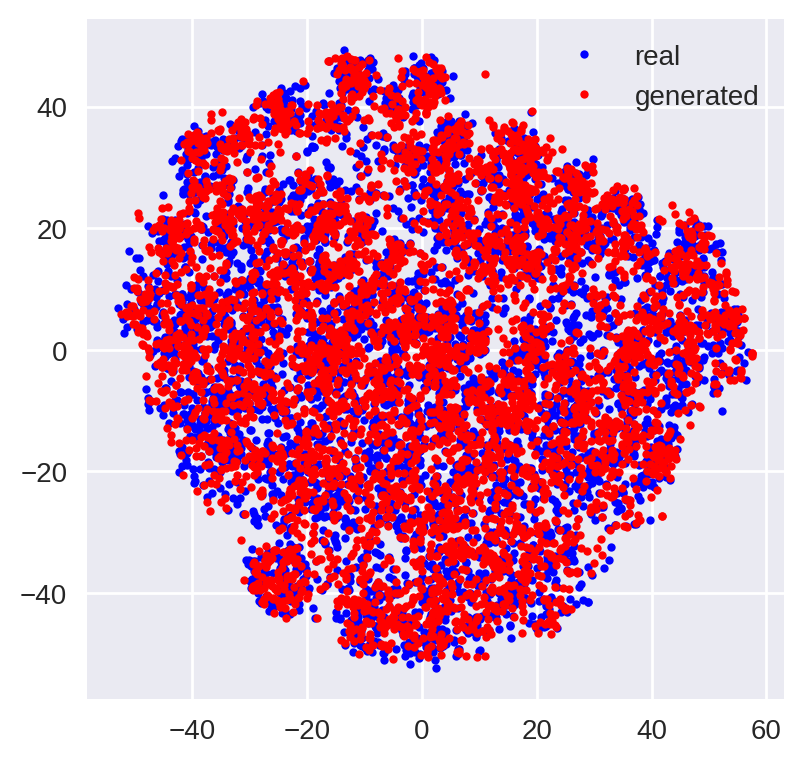

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(4.5,4.5), dpi=200)

ax.plot(x_real_embedded[:5000, 0], x_real_embedded[:5000, 1], 'bo', markersize=3, 
        label='real', color='blue')
ax.plot(x_fake_embedded[:5000, 0], x_fake_embedded[:5000, 1],'bo', markersize=3,
        label='generated',
        color='red')
plt.legend()

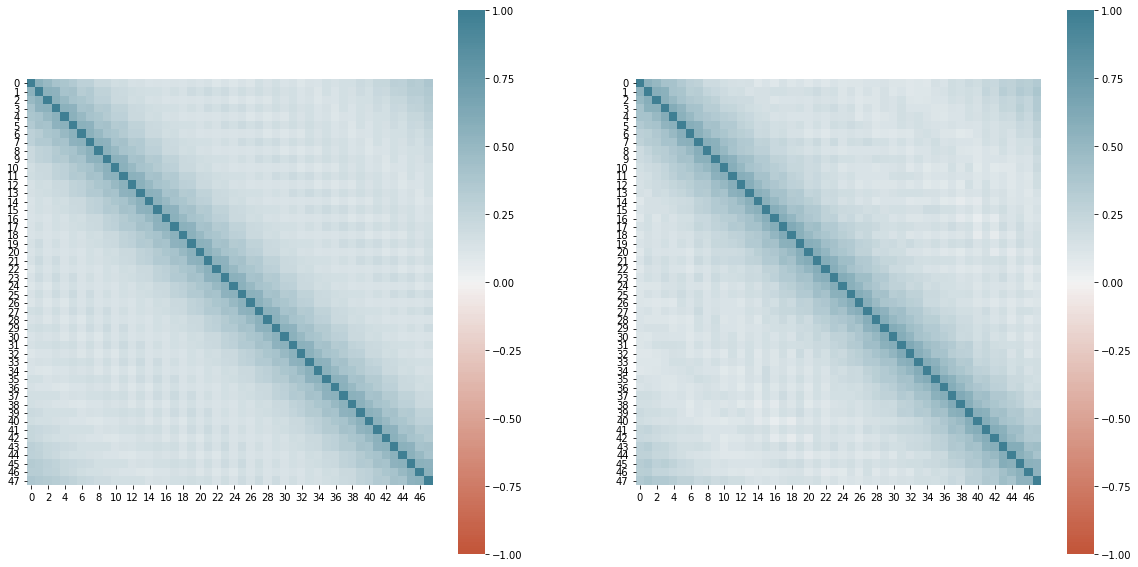

In [ ]:
data_real = x_real[:,1,:].numpy().squeeze()
data_gen = x_fake[:,1,:].cpu().numpy().squeeze()

df_real = pd.DataFrame(data_real)
df_fake = pd.DataFrame(data_gen)
corr_real = df_real.corr()
corr_fake = df_fake.corr()

fig, axs = plt.subplots(ncols=2, figsize=(4.5, 4.5), dpi=200)
sns.heatmap(
    corr_real,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, ax = axs[0]
    )
#axs[0].set_title("Correlation matrix of {} {} h samples".format(size, window_width))
#axs[1].set_title("Correlation matrix of {} {} h generated samples, model: {}".format(size,
  #                                                                      window_width, model_cls.__name__))
sns.heatmap(
        corr_fake,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True, ax = axs[1]
        )

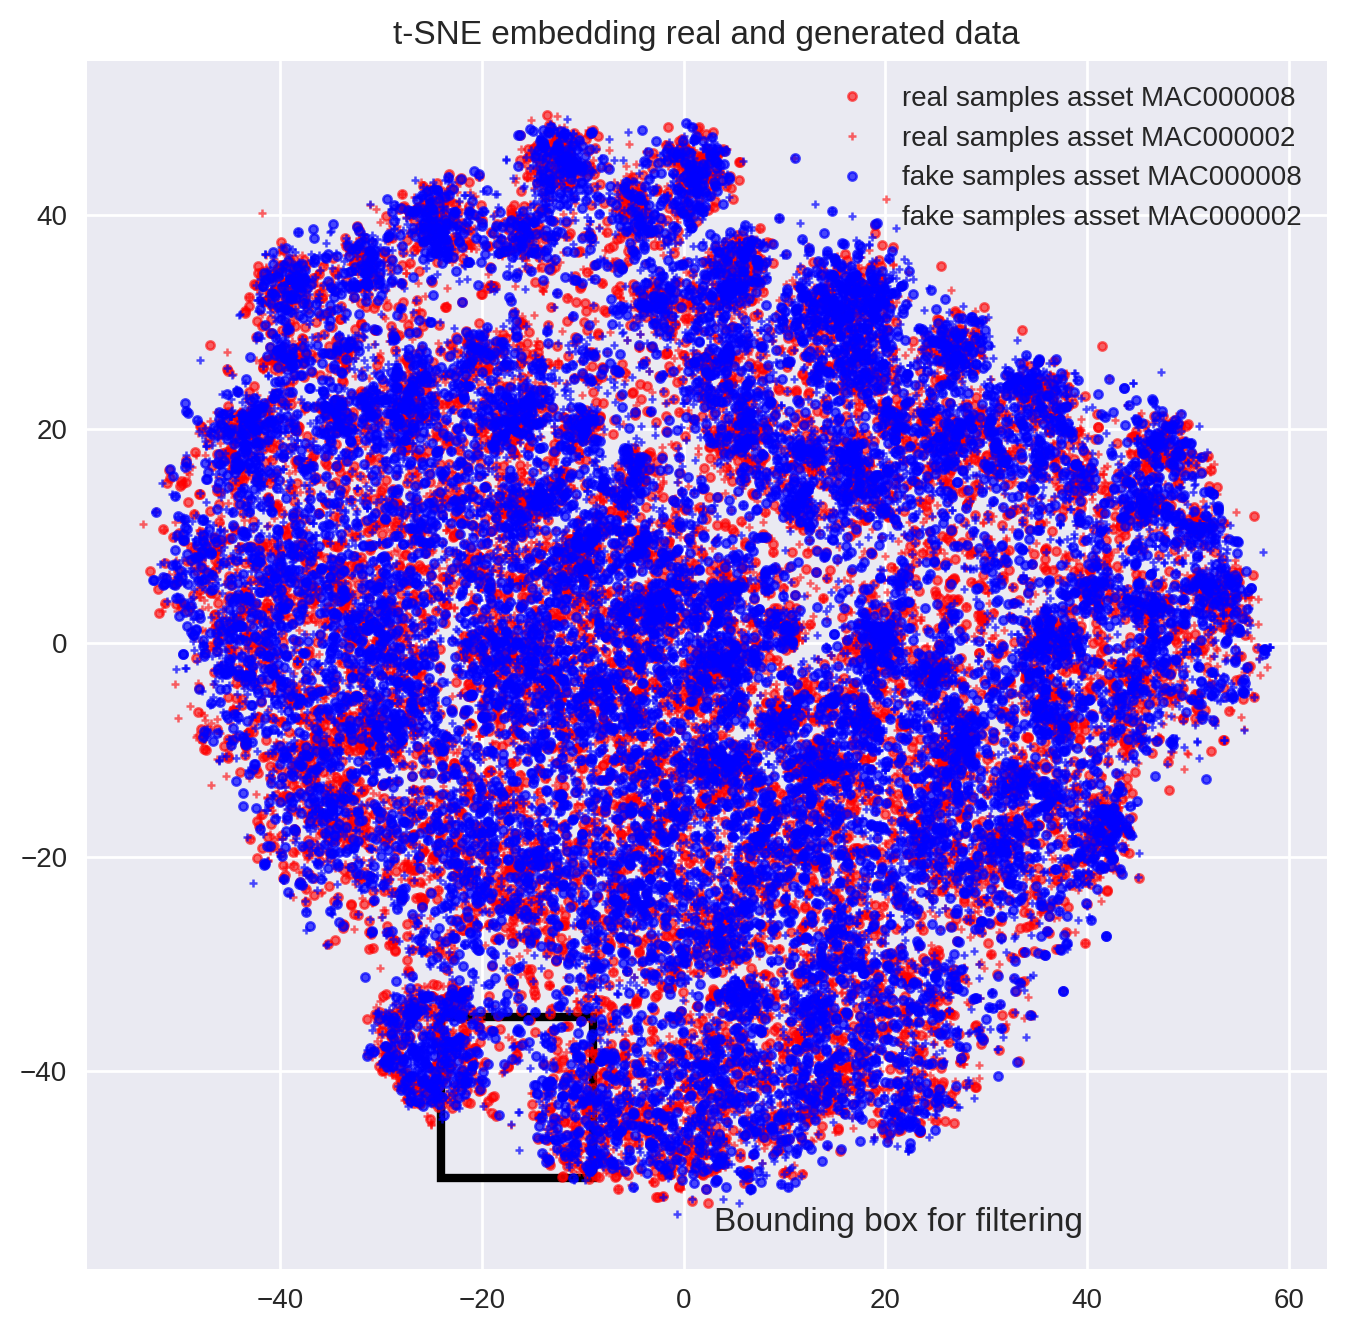

In [ ]:
from matplotlib.patches import Rectangle
import matplotlib

matplotlib.rcParams.update({'font.size': 12})
plt.style.use('seaborn')

fig,ax=plt.subplots(figsize=(8,8), dpi=200)

size = len(x_real)
asset_1 = dataset.assets[0]
asset_2 = dataset.assets[1]
red_real, = plt.plot(x_real_embedded[:size, 0], x_real_embedded[:size, 1],'bo',markersize=3,
         markeredgewidth=0.9, linestyle='none', color='red', alpha=0.6, label=f'real samples asset {asset_1}')
blue_real, = plt.plot(x_real_embedded[size:, 0], x_real_embedded[size:, 1],'+',markersize=3,
         markeredgewidth=0.9,linestyle='none', color='red', alpha=0.6, label = f'real samples asset {asset_2}')

red_fake, = plt.plot(x_fake_embedded[:size, 0], x_fake_embedded[:size, 1],'bo',markersize=3,
         markeredgewidth=0.9,linestyle='none', color='blue', alpha=0.7, label = f'fake samples asset {asset_1}')
blue_fake, = plt.plot(x_fake_embedded[size:, 0], x_fake_embedded[size:, 1],'+',markersize=3,
         markeredgewidth=0.9,linestyle='none', color='blue', alpha=0.7, label = f'fake samples asset {asset_2}')
#ax.scatter(x_fake_embedded[:, 0], x_fake_embedded[:, 1], alpha=0.4, label="generated data")

plt.title('t-SNE embedding real and generated data')
ax.add_patch(Rectangle((-24, -50),15, 15,fc ='none',color='black', ec ='black',lw = 3) )
plt.text(3, -55,'Bounding box for filtering')
plt.legend()

In [ ]:
def filter_points_in_box(X_real_embed, X_fake_embed, ll = np.array([5, -50]), ur=np.array([15, -40])):

  xy_pts_real = X_real_embed[:,[0,1]]
  xy_pts_fake = X_fake_embed[:, [0,1]]

  inidx_real = np.all((ll <= xy_pts_real) & (xy_pts_real <= ur), axis=1)
  inidx_fake = np.all((ll <= xy_pts_fake) & (xy_pts_fake <= ur), axis=1)

  return inidx_real, inidx_fake






In [ ]:
x_real_embedded_feature_1 = x_real_embedded[:size]
x_real_embedded_feature_2 = x_real_embedded[size:]

x_fake_embedded_feature_1 = x_fake_embedded[:size]
x_fake_embedded_feature_2 = x_fake_embedded[size:]

ind_real_feature_1, ind_fake_feature_1 = filter_points_in_box(x_real_embedded_feature_1, x_fake_embedded_feature_1)
ind_real_feature_2, ind_fake_feature_2 = filter_points_in_box(x_real_embedded_feature_2, x_fake_embedded_feature_2)

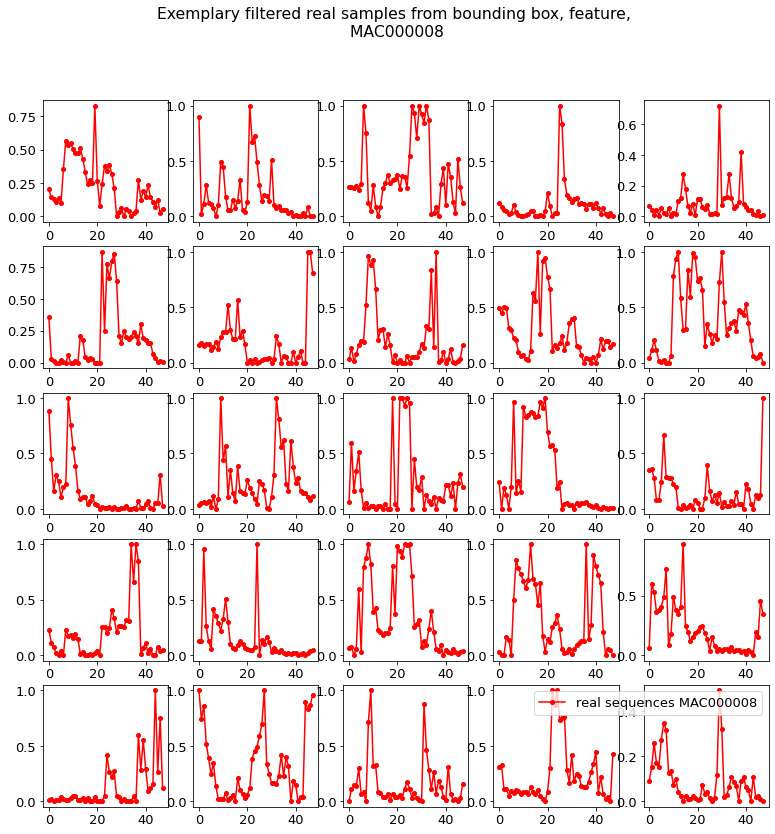

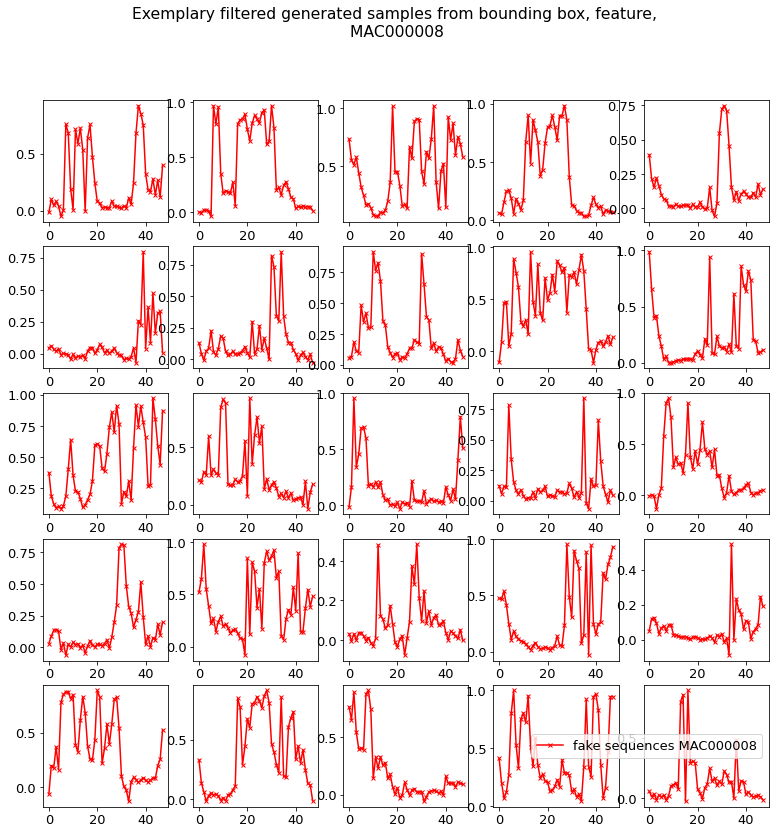

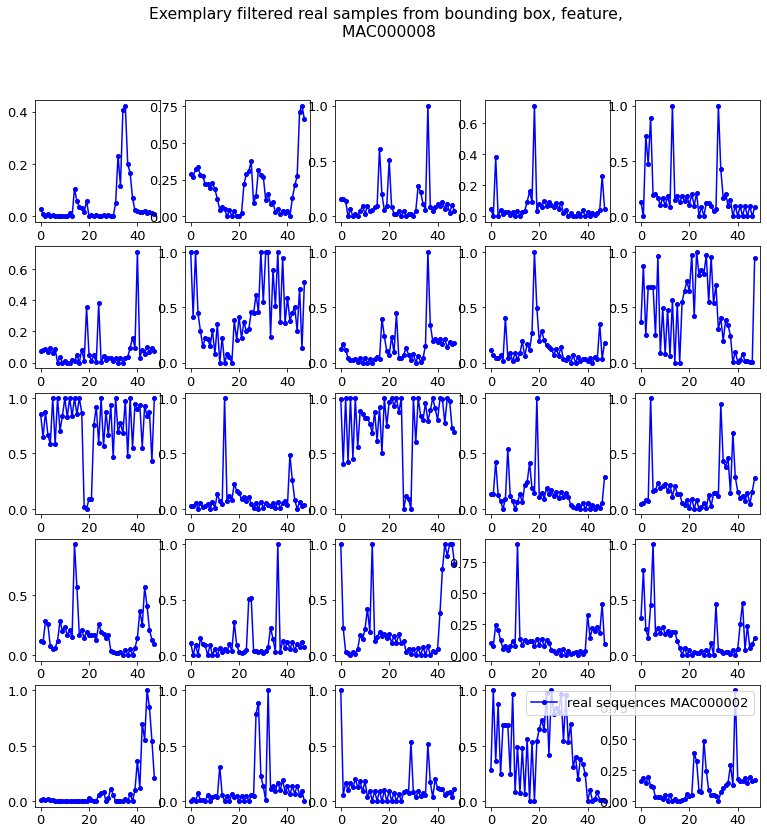

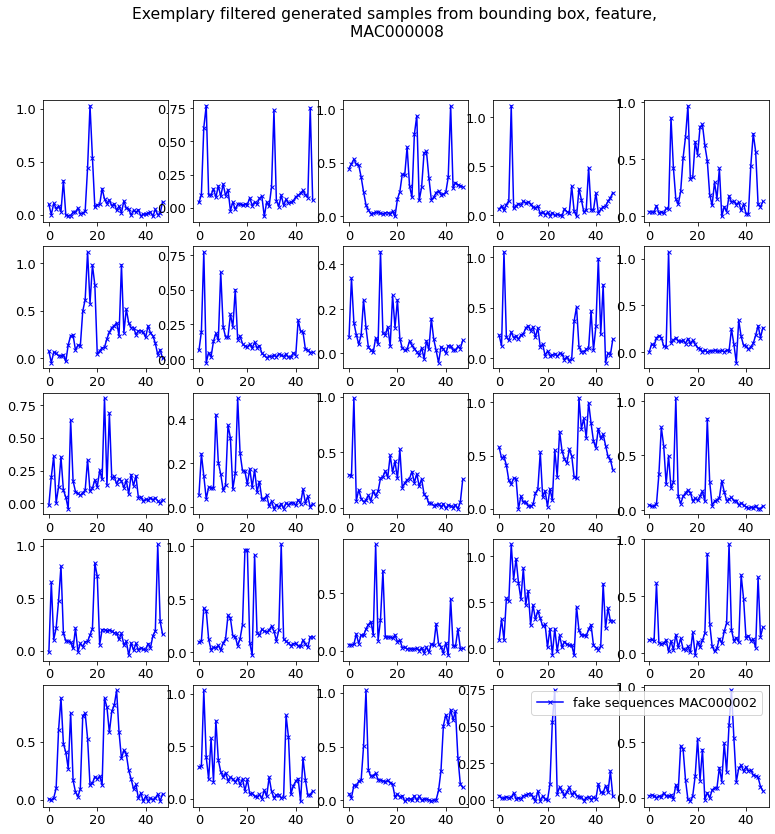

In [ ]:
import matplotlib

ind_real_feature_1, ind_fake_feature_1 = filter_points_in_box(x_real_embedded_feature_1, x_fake_embedded_feature_1)
ind_real_feature_2, ind_fake_feature_2 = filter_points_in_box(x_real_embedded_feature_2, x_fake_embedded_feature_2)

x_real_filtered_1 = x_real[ind_real_feature_1,0,:]
x_real_filtered_2 = x_real[ind_real_feature_2,1,:]

x_gen_filtered_1 = x_fake[ind_fake_feature_1, 0, :]
x_gen_filtered_2 = x_fake[ind_fake_feature_2, 1, :]

matplotlib.rcParams.update({'font.size': 13})
plt.figure(figsize=(13,13))
for k in range(25):
  plt.subplot(5,5, k+1)
  plt.plot(x_real_filtered_1[k,:], color='red', marker='o', markersize=4, label=f'real sequences {dataset.assets[0]}')
plt.legend()
plt.suptitle(f'Exemplary filtered real samples from bounding box, feature,\n {dataset.assets[0]}')
plt.show()

plt.figure(figsize=(13,13))
for k in range(25):
  plt.subplot(5,5, k+1)
  plt.plot(x_gen_filtered_1[k,:], color='red', marker='x', markersize=4, label=f'fake sequences {dataset.assets[0]}')
plt.legend()
plt.suptitle(f'Exemplary filtered generated samples from bounding box, feature,\n {dataset.assets[0]}')
plt.show()

plt.figure(figsize=(13,13))
for k in range(25):
  plt.subplot(5,5, k+1)
  plt.plot(x_real_filtered_2[k,:], color='blue', marker='o', markersize=4, label=f'real sequences {dataset.assets[1]}')
plt.legend()
plt.suptitle(f'Exemplary filtered real samples from bounding box, feature,\n {dataset.assets[0]}')
plt.show()

plt.figure(figsize=(13,13))
for k in range(25):
  plt.subplot(5,5, k+1)
  plt.plot(x_gen_filtered_2[k,:], color='blue', marker='x', markersize=4, label=f'fake sequences {dataset.assets[1]}')
plt.legend()
plt.suptitle(f'Exemplary filtered generated samples from bounding box, feature,\n {dataset.assets[0]}')
plt.show()


In [ ]:
def plot_histograms(data_real, data_fake,):
    """
    plot histograms of real and generated data in one plot.

    """
    # now plot histograms
    fig, ax = plt.subplots(figsize=(13, 9))
    for pos in ['right', 'top', 'bottom', 'left']:
        plt.gca().spines[pos].set_visible(False)
    bins = np.linspace(0, 1, 100)
    ax.hist(data_real.cpu().numpy().flatten(), bins, alpha=0.5, label='real data', color='black')
    ax.hist(data_fake.cpu().numpy().flatten(), bins, alpha=0.5, label='generated data')
    plt.title("Histogram of flattened training and generated data")
    plt.legend()
    ax.set_ylabel('counts')

    return fig

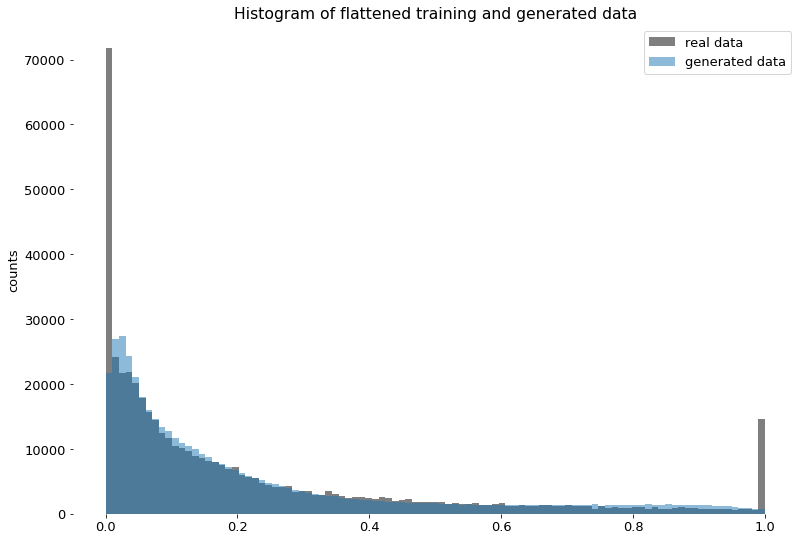

In [ ]:
fig_hist = plot_histograms(x_real, x_fake)

Define dataset with labeled data:

In [ ]:
class DataSetforClassification(Dataset):
    """
    Dataset for testing the discriminative score in the evaluation of the model.
    Labels real data samples as '1' and fake samples as '0'.
    """

    def __init__(self, real_data: torch.Tensor, fake_data: torch.Tensor):
        self.real_data = real_data
        self.fake_data = fake_data
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def __len__(self):
        len_data = len(self.real_data) + len(self.fake_data)
        return len_data

    def __getitem__(self, item):
        seq_len = self.real_data.shape[-1]
        feature_dim = self.real_data.shape[1]
        if item >= len(self.real_data):
            sample = self.fake_data[item - len(self.real_data)].reshape(seq_len, feature_dim)
            sample = sample.to(self.device)
            label = torch.tensor(0).to(self.device)
        else:
            sample = self.real_data[item].reshape(seq_len, feature_dim).to(self.device)
            label = torch.tensor(1).to(self.device)
        return sample, label

Test Random forest/ Decision tree classifiers on labeled data:

In [ ]:
x_real = load_real_data(dataset, size=1000)
x_real = add_gaussian_noise(x_real, variance=0.001).type(torch.float32)
x_fake = generate_samples(gen_model, size=1000)
x_fake = add_gaussian_noise(x_fake, variance=0.001).type(torch.float32)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from torch.utils.data import random_split

dataset_clf = DataSetforClassification(x_real, x_fake)

train_set, test_set = random_split(dataset_clf, [1600, 400])
train_loader = DataLoader(train_set, batch_size=1600, shuffle=True)
[X_train, y_train] = next(iter(train_loader))
X_train = X_train[:,:,0]
X_train = X_train.reshape(train_loader.batch_size, 48).detach().cpu().numpy()
y_train = y_train.reshape(train_loader.batch_size, 1).detach().cpu().numpy()

forest = RandomForestClassifier(n_estimators=100, criterion='entropy')
forest.fit(X_train, y_train.ravel())

test_loader = DataLoader(test_set, batch_size=400, shuffle=True)
[X_test, y_test] = next(iter(test_loader))
X_test = X_test[:,:,0]
X_test = X_test.reshape(test_loader.batch_size, 48).detach().cpu().numpy()
y_test = y_test.reshape(test_loader.batch_size, 1).detach().cpu().numpy()

y_predict = forest.predict((X_test))
acc_forest = accuracy_score(y_predict, y_test)

tree_clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=10)
tree_clf.fit(X_train, y_train)

y_pred_tree = tree_clf.predict((X_test))
acc_tree = accuracy_score(y_pred_tree, y_test)

print(f'Accuracy Random Forest: {acc_forest},  Accuracy decision tree: {acc_tree}')


Accuracy Random Forest: 0.6225,  Accuracy decision tree: 0.59


Use a random projection matrix to map each feature of the data in a one-dimensional space:

In [ ]:
def random_projection(x_real, x_fake, n_dims=1):
    """
    Idea: project the sequences on a one or lower dimensional subspace.
    """

    num_samples, num_features, seq_len = x_real.shape
    x_real = x_real.cpu().numpy()
    x_fake = x_fake.cpu().numpy()
    W = np.random.randn(1, seq_len, n_dims)
    x_embedded = (x_real @ W).squeeze()
    x_fake_embedded = (x_fake @ W).squeeze()

    return x_embedded, x_fake_embedded


In [ ]:
def load_real_data(dataset, size=1000):
  idx = np.random.permutation(len(dataset))[:size]
  data = dataset.data
  return data[idx]

In [ ]:
x_fake = generate_samples(gen_model, size=5000)
x_real = load_real_data(dataset, size=5000)

x_real_projected, x_fake_projected = random_projection(x_real, x_fake)

In [ ]:
x_real_projected.shape

(5000, 2)

Text(0.5, 0.98, 'Histograms of projected data')

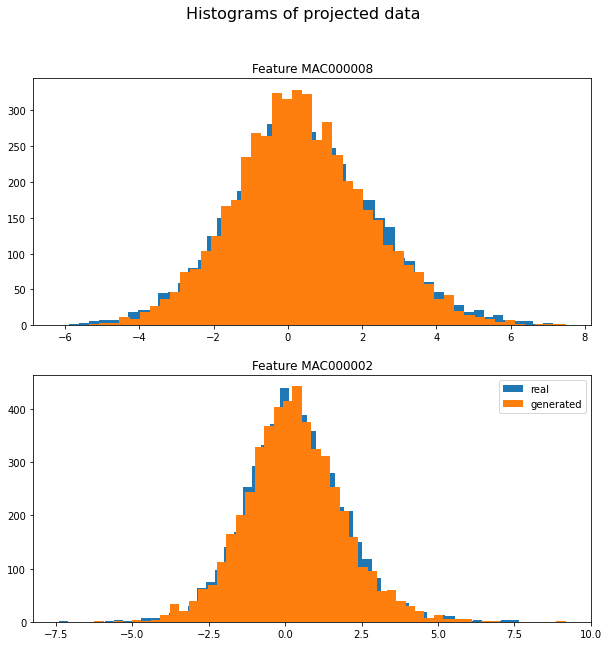

In [ ]:
num_features = 2
plt.figure(figsize=(10,10))
#bins = np.linspace(0, 1, 100)
for i in range(num_features):
  plt.subplot(num_features,1, i+1)
  plt.hist(x_real_projected[:,i],bins=50, label='real')
  plt.hist(x_fake_projected[:,i],bins=50, label='generated')
  plt.title(f'Feature {dataset.assets[i]}')
plt.legend()
plt.suptitle(f'Histograms of projected data', fontsize=16)
